In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!mkdir -p hateful_memes
!unzip -q gdrive/MyDrive/data.zip -d /content/hateful_memes/

!pip install --quiet \
    transformers accelerate safetensors \
    git+https://github.com/openai/CLIP.git \
    albumentations torchmetrics scikit-learn matplotlib

In [ ]:
import os, json
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AUROC
from sklearn.metrics import precision_score, recall_score, f1_score

from transformers import CLIPProcessor, CLIPModel

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2 * (probs * targets).sum()
        den = probs.sum() + targets.sum()
        return 1 - (num + self.smooth) / (den + self.smooth)

In [ ]:
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT  = Path('/content/hateful_memes')
BATCH_SIZE = 16
EPOCHS     = 10
LR_HEAD    = 1e-4
LR_BACKBONE= 1e-6
MAX_SEQ    = 77

In [ ]:
def collate_fn(batch):
    imgs, txts, lbls = zip(*batch)
    return list(imgs), list(txts), torch.stack(lbls)
class HatefulMemesDataset(Dataset):
    def __init__(self, root, split):
        self.root = root
        self.samples = [json.loads(l) for l in open(root/ f"{split}.jsonl")]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        item = self.samples[idx]
        img = Image.open(self.root/item['img']).convert('RGB')
        return img, item['text'], torch.tensor(item['label'], dtype=torch.float)
train_ds = HatefulMemesDataset(DATA_ROOT, 'train')
val_ds   = HatefulMemesDataset(DATA_ROOT, 'dev')
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,num_workers=0, collate_fn=collate_fn)

In [ ]:
processor  = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)

class CLIPClassifier(nn.Module):
    def __init__(self, clip):
        super().__init__()
        self.clip = clip
        for p in self.clip.parameters(): p.requires_grad = False
        vis_layers = clip.config.vision_config.num_hidden_layers
        txt_layers = clip.config.text_config.num_hidden_layers
        for name, p in self.clip.named_parameters():
            if 'vision_model.encoder.layers.' in name:
                idx = int(name.split('vision_model.encoder.layers.')[1].split('.')[0])
                if idx >= vis_layers - 4:
                    p.requires_grad = True
            if 'text_model.encoder.layers.' in name:
                idx = int(name.split('text_model.encoder.layers.')[1].split('.')[0])
                if idx >= txt_layers - 4:
                    p.requires_grad = True
        dim = clip.config.projection_dim * 2
        self.mlp = nn.Sequential(
            nn.Linear(dim, 1024), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512,   1)
        )
    def forward(self, images, texts):
        inputs = processor(images=images, text=texts, return_tensors='pt', padding=True,
                           truncation=True, max_length=MAX_SEQ).to(device)
        out    = self.clip(**inputs)
        feats  = torch.cat([out.image_embeds, out.text_embeds], dim=1)
        return self.mlp(feats).squeeze(-1)

model = CLIPClassifier(clip_model).to(device)

In [ ]:
labels_list = [s['label'] for s in train_ds.samples]
neg, pos    = labels_list.count(0), labels_list.count(1)
pos_weight  = torch.tensor([neg/pos], device=device)
criterion   = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
bce, dice   = criterion, nn.MSELoss()
optimizer   = optim.AdamW([
    {'params': model.mlp.parameters(), 'lr': LR_HEAD},
], weight_decay=1e-4)
scheduler   = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
auc_metric  = AUROC(task='binary').to(device)

In [ ]:
history = {
    'train_loss': [], 'val_loss': [],
    'auc': [], 'precision': [], 'recall': [], 'f1': []
}

def train_epoch():
    model.train(); total_loss = 0
    for imgs, txts, lbls in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()
        logits = model(imgs, txts)
        loss   = criterion(logits, lbls.to(device))
        loss.backward(); optimizer.step(); scheduler.step()
        total_loss += loss.item() * lbls.size(0)
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def eval_epoch():
    model.eval(); auc_metric.reset()
    all_labels, all_probs, all_preds = [], [], []
    total_loss = 0
    for imgs, txts, lbls in tqdm(val_loader, desc='Val'):
        logits = model(imgs, txts)
        loss   = criterion(logits, lbls.to(device))
        probs  = torch.sigmoid(logits).cpu()
        preds  = (probs >= 0.5).int()
        all_labels.extend(lbls.int().tolist())
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        auc_metric.update(probs.to(device), lbls.to(device))
        total_loss += loss.item() * lbls.size(0)
    avg_loss  = total_loss / len(val_loader.dataset)
    auc_score = auc_metric.compute().item()
    prec      = precision_score(all_labels, all_preds)
    rec       = recall_score(all_labels, all_preds)
    f1        = f1_score(all_labels, all_preds)
    return avg_loss, auc_score, prec, rec, f1

In [ ]:
best_auc = 0
for epoch in range(1, EPOCHS+1):
    tr_loss = train_epoch()
    val_loss, auc, prec, rec, f1 = eval_epoch()
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(val_loss)
    history['auc'].append(auc)
    history['precision'].append(prec)
    history['recall'].append(rec)
    history['f1'].append(f1)
    print(f"Epoch {epoch} — train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | "
          f"AUC={auc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), 'best_memes_classifier.pth')
        print(f"→  New best AUC: {best_auc:.4f}")

Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 — train_loss=0.1806 | val_loss=1.3367 | AUC=0.7094 | Prec=0.6737 | Rec=0.5120 | F1=0.5818
→  New best AUC: 0.7094


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 — train_loss=0.1626 | val_loss=1.4790 | AUC=0.7091 | Prec=0.6744 | Rec=0.4640 | F1=0.5498


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 — train_loss=0.1412 | val_loss=1.6472 | AUC=0.7106 | Prec=0.6818 | Rec=0.4200 | F1=0.5198
→  New best AUC: 0.7106


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 — train_loss=0.1299 | val_loss=1.8388 | AUC=0.7113 | Prec=0.7015 | Rec=0.3760 | F1=0.4896
→  New best AUC: 0.7113


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 — train_loss=0.1093 | val_loss=1.8096 | AUC=0.7078 | Prec=0.6887 | Rec=0.4160 | F1=0.5187


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 — train_loss=0.0930 | val_loss=2.1186 | AUC=0.7102 | Prec=0.7203 | Rec=0.3400 | F1=0.4620


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 — train_loss=0.0849 | val_loss=2.3094 | AUC=0.7082 | Prec=0.7179 | Rec=0.3360 | F1=0.4578


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 — train_loss=0.0720 | val_loss=2.0293 | AUC=0.7093 | Prec=0.6948 | Rec=0.4280 | F1=0.5297


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 — train_loss=0.0690 | val_loss=1.6419 | AUC=0.7116 | Prec=0.6699 | Rec=0.5520 | F1=0.6053
→  New best AUC: 0.7116


Train:   0%|          | 0/532 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 — train_loss=0.0580 | val_loss=2.3302 | AUC=0.7117 | Prec=0.7279 | Rec=0.3960 | F1=0.5130
→  New best AUC: 0.7117


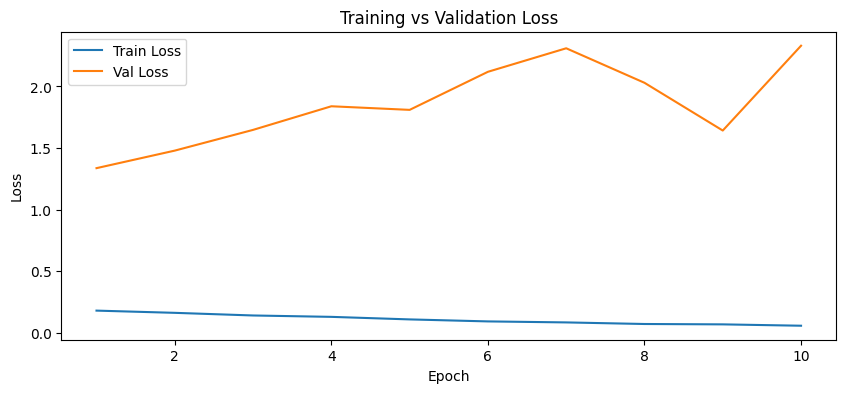

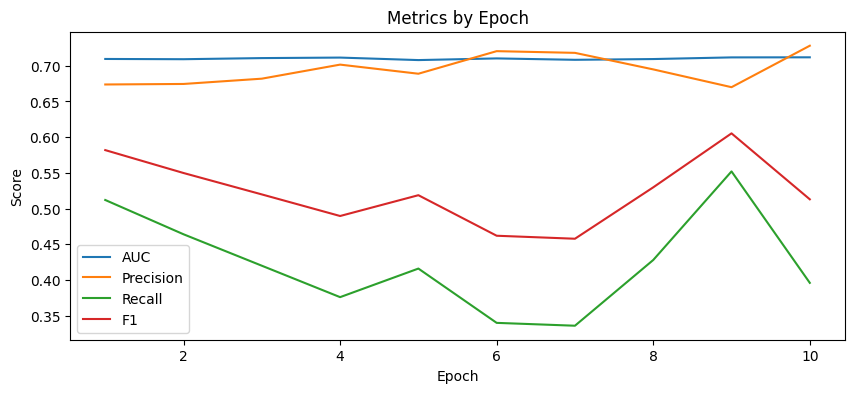

In [ ]:
epochs = list(range(1, EPOCHS+1))
plt.figure(figsize=(10,4))
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, history['auc'], label='AUC')
plt.plot(epochs, history['precision'], label='Precision')
plt.plot(epochs, history['recall'], label='Recall')
plt.plot(epochs, history['f1'], label='F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Metrics by Epoch')
plt.legend()
plt.show()